# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных
Данные геологоразведки трёх регионов находятся в файлах:

    geo_data_0.csv. Скачать датасет
    geo_data_1.csv. Скачать датасет
    geo_data_2.csv. Скачать датасет
    id — уникальный идентификатор скважины;
    f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
    product — объём запасов в скважине (тыс. баррелей).

Условия задачи:

    Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
    При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для расчёта прибыли.
    Бюджет на разработку скважин в регионе — 10 млрд рублей.
    Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
    После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Комментарий наставника
<span style="color:green">Хорошо, приступим к работе.</span>

# 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

rnd_state = 202008

In [2]:
df_geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

all_df = [df_geo_0,df_geo_1,df_geo_2]

In [3]:
#посомтрим данные
for i in all_df:
    display(i.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [4]:
#посмотрим типы данных и пропуски
for i in all_df:
    #display(i.isnull().sum())
    display(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

пропусков в данных нету

In [5]:
#посомтрим дубликаты
for i in all_df:
    display(i.nunique())

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

в данных присутствуют дубликаты по id, удалим их

In [6]:
#for i in all_df:
#    i = i.drop_duplicates(subset='id', keep=False).reset_index(drop=True)
df_geo_0 = df_geo_0.drop_duplicates(subset='id', keep=False).reset_index(drop=True)
df_geo_1 = df_geo_1.drop_duplicates(subset='id', keep=False).reset_index(drop=True)
df_geo_2 = df_geo_2.drop_duplicates(subset='id', keep=False).reset_index(drop=True)

In [7]:
#удалим везде id, т.к. он нам не нужен для расчета моделей
for i in all_df:
    i.drop('id', axis=1, inplace=True)

## Проведем анализ данных

### df_geo_0

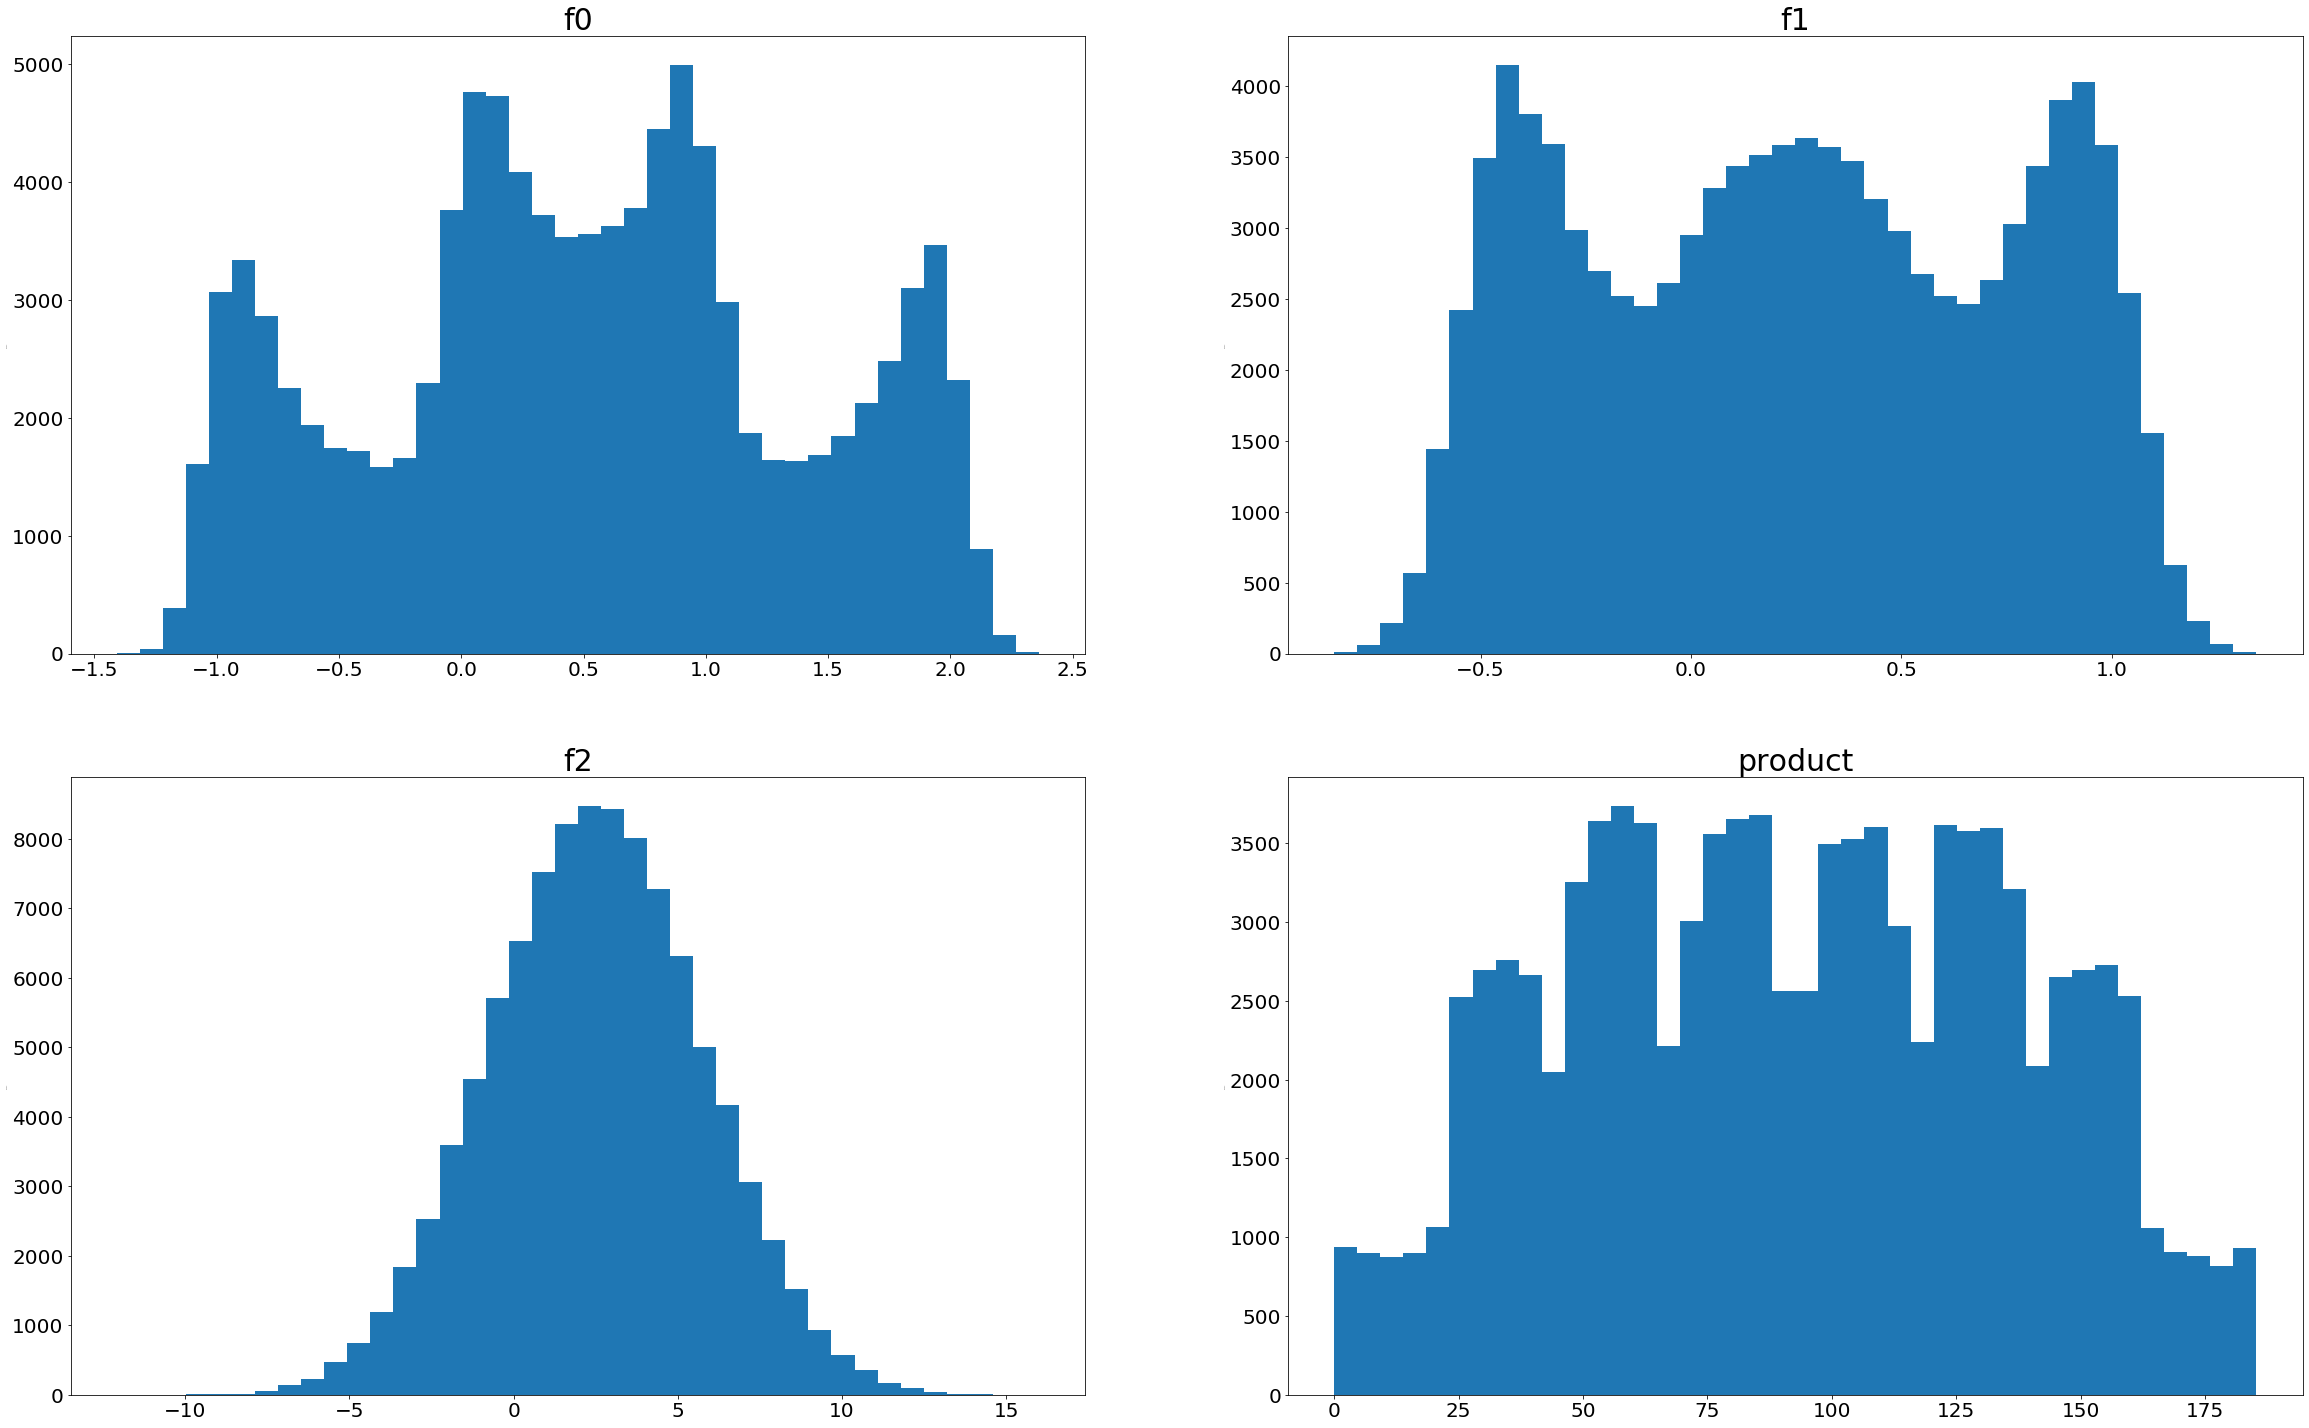

In [8]:
#посмотрим распределение данных
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(40,25))
column_list = ['f0', 'f1', 'f2', 'product']

count = 0
for r in range(rows):
    for c in range(cols):
        ax = df_geo_0[column_list[count]].plot(kind='hist', bins=40, ax=axes[r,c], fontsize=20, title=column_list[count])
        ax.set_title(column_list[count])
        ax.title.set_size(30)
        ax.yaxis.label.set_size(0)
        count += 1

только f2 имеет нормальное распределение

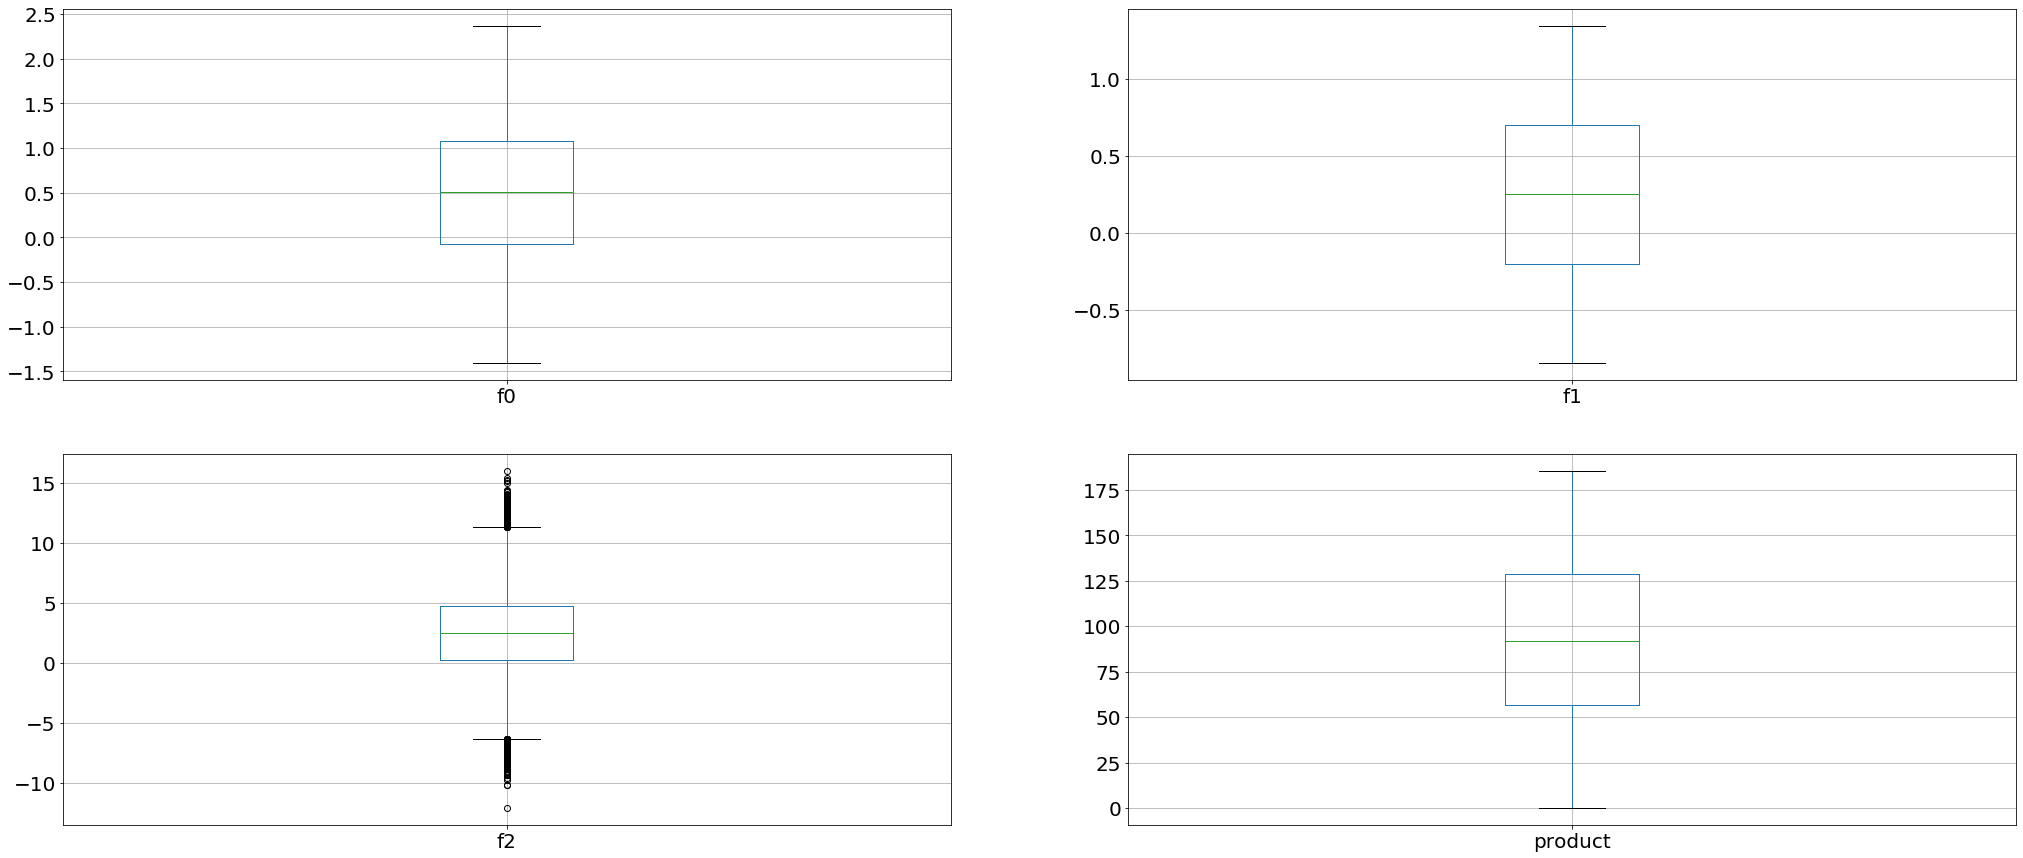

In [9]:
#посмотрим выбросы данных
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(35,15))
column_list = ['f0', 'f1', 'f2', 'product']

count = 0
for r in range(rows):
    for c in range(cols):
        ax = df_geo_0.boxplot(column=column_list[count], ax=axes[r,c], fontsize=20)
        count += 1

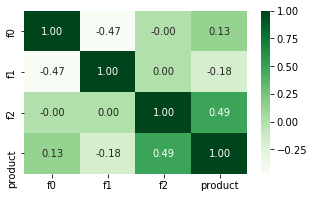

In [10]:
#посмотрим коэф. корреляции методом Спирмена
plt.figure(figsize=(5,3))
sns.heatmap(df_geo_0.corr(method='spearman'), annot=True, cmap="Greens", fmt='.2f')

наблюдается зависимость у f2 и product

### df_geo_1

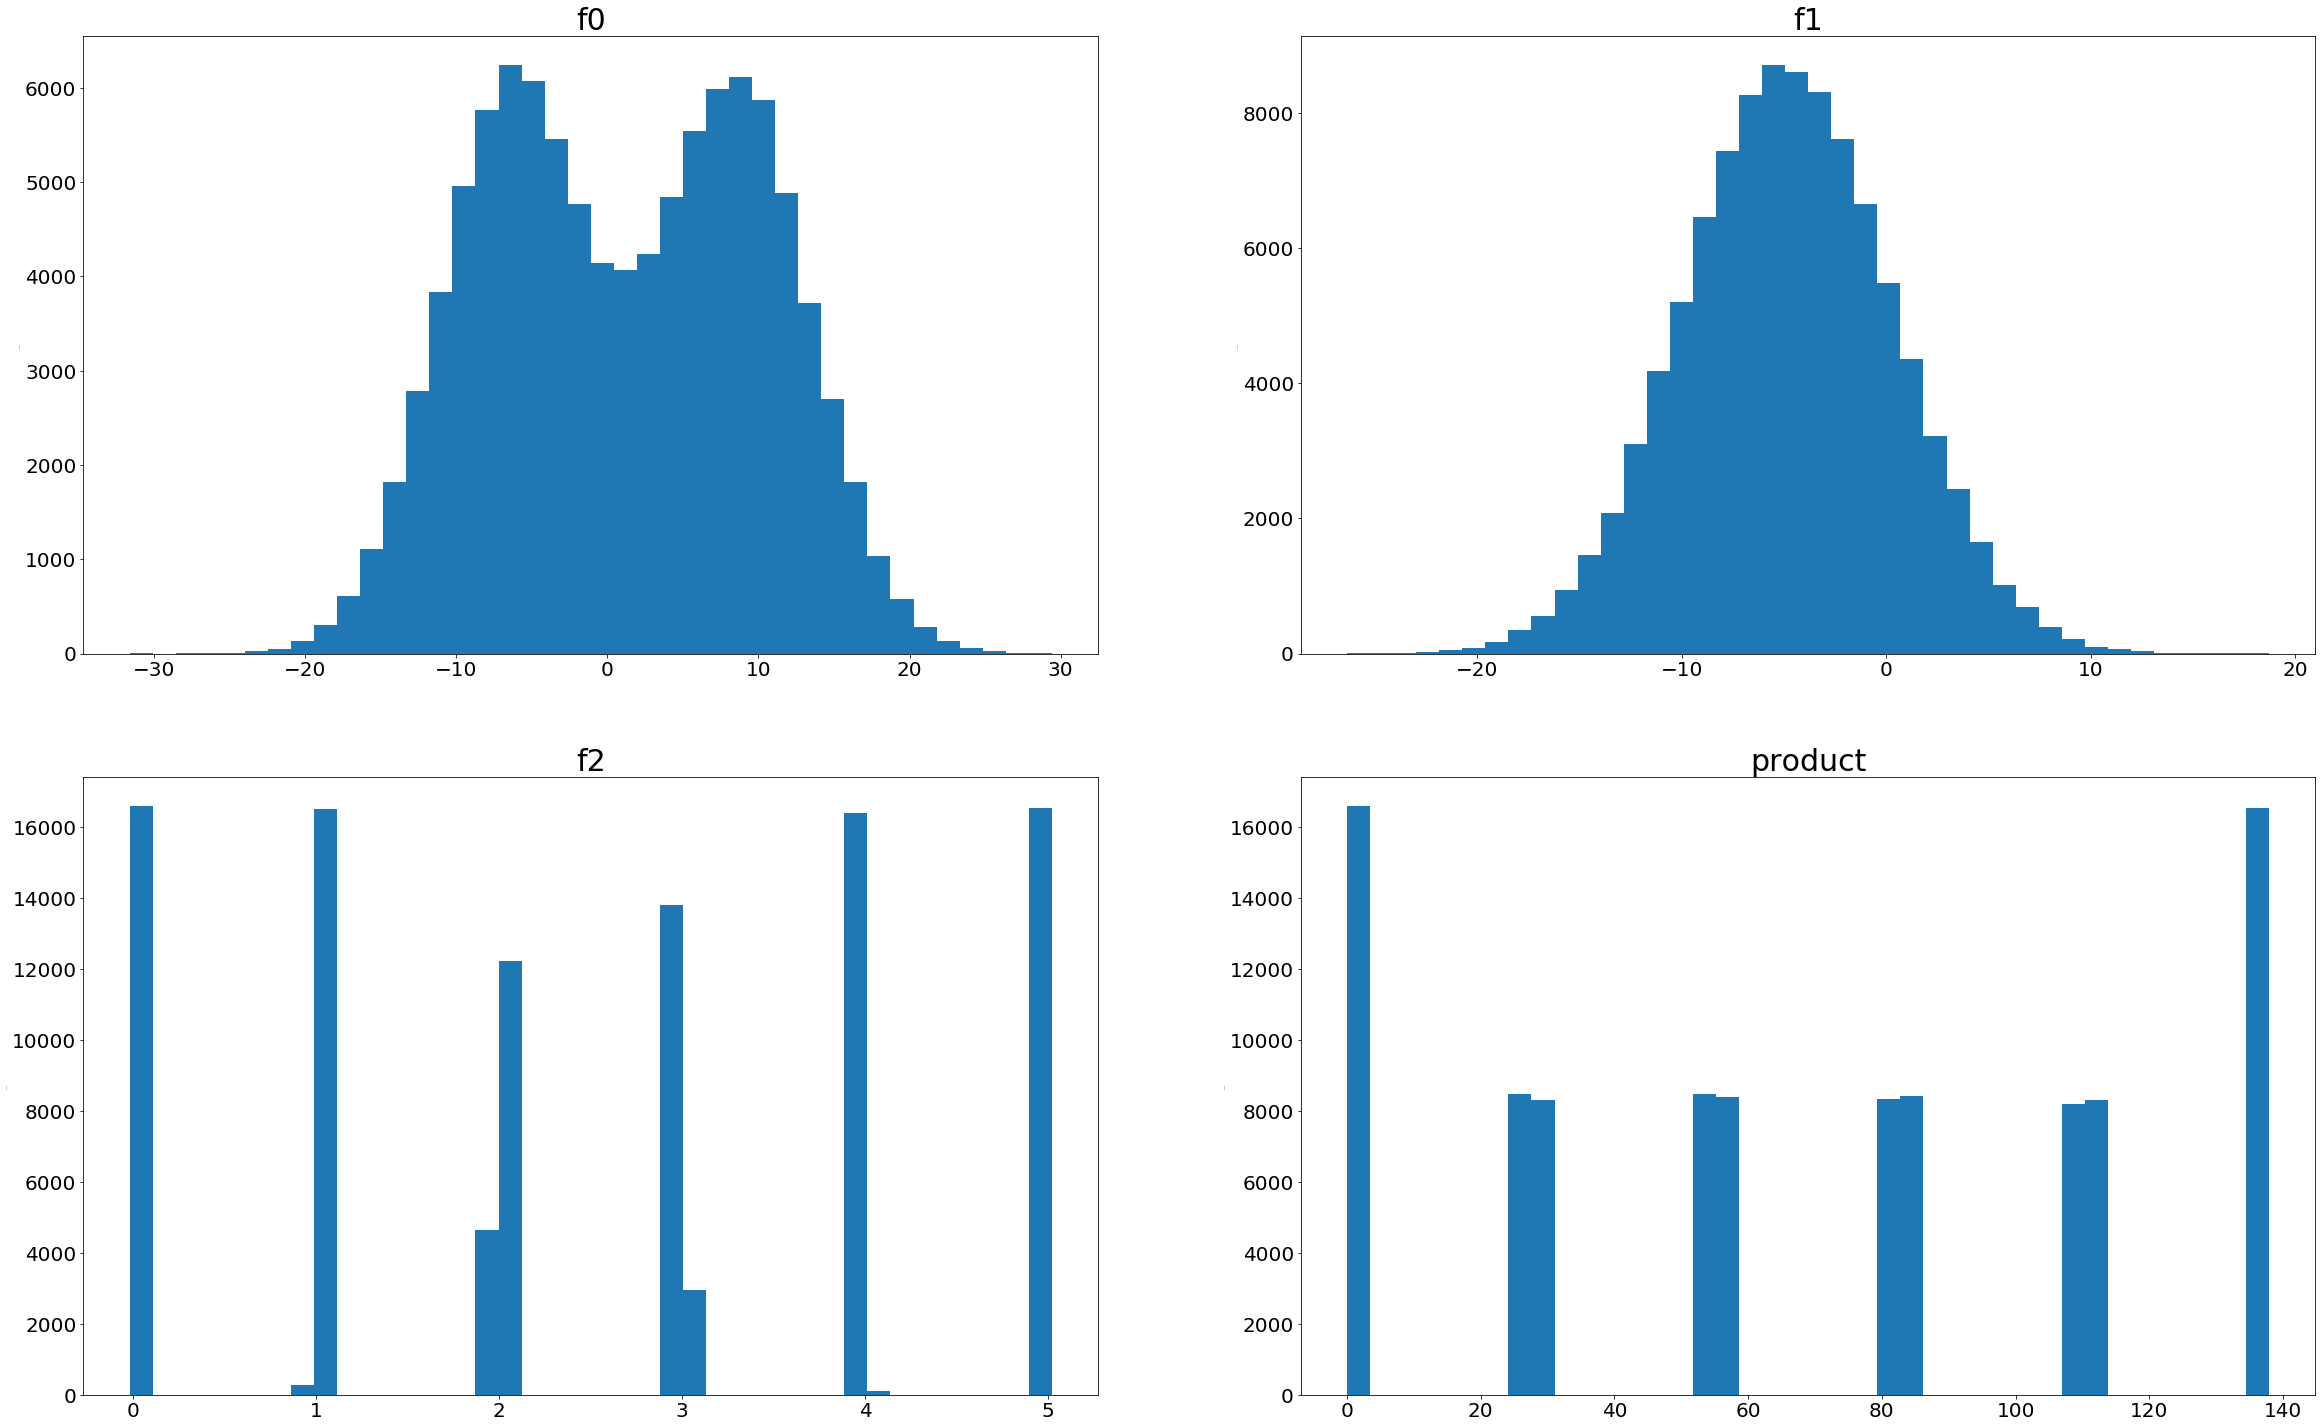

In [11]:
#посмотрим распределение данных
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(40,25))
column_list = ['f0', 'f1', 'f2', 'product']

count = 0
for r in range(rows):
    for c in range(cols):
        ax = df_geo_1[column_list[count]].plot(kind='hist', bins=40, ax=axes[r,c], fontsize=20, title=column_list[count])
        ax.set_title(column_list[count])
        ax.title.set_size(30)
        ax.yaxis.label.set_size(0)
        count += 1

только f1 имеет нормальное распределение

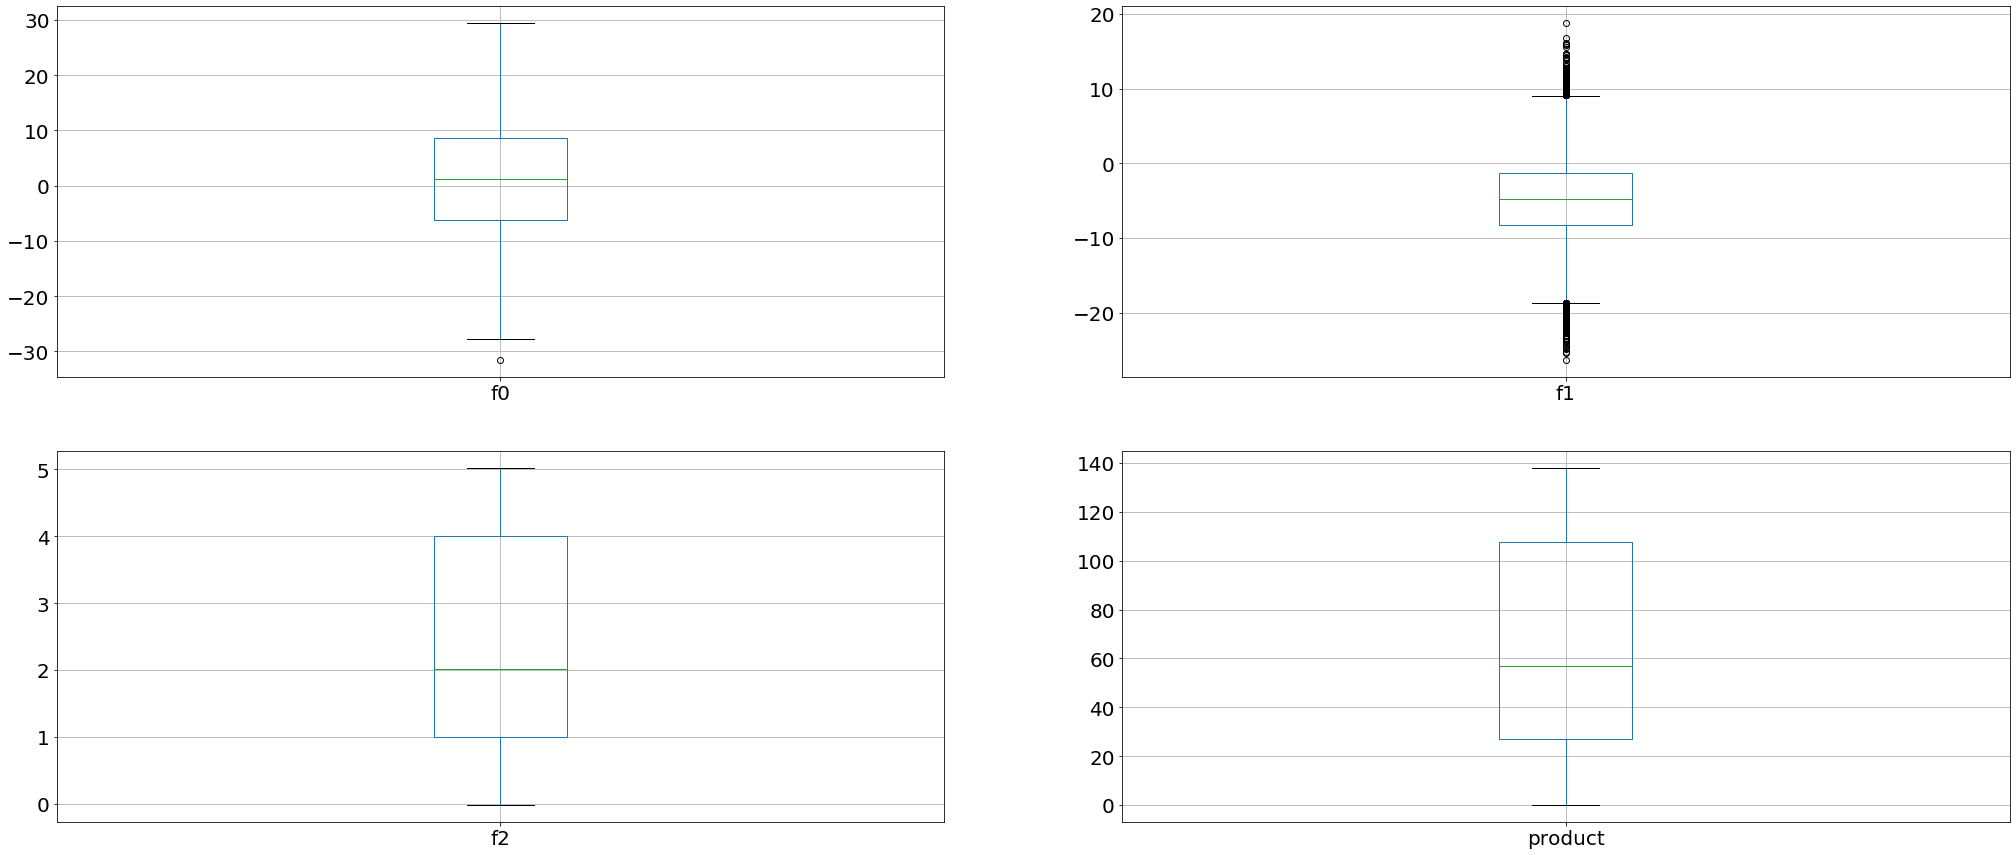

In [12]:
#посмотрим выбросы данных
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(35,15))
column_list = ['f0', 'f1', 'f2', 'product']

count = 0
for r in range(rows):
    for c in range(cols):
        ax = df_geo_1.boxplot(column=column_list[count], ax=axes[r,c], fontsize=20)
        count += 1

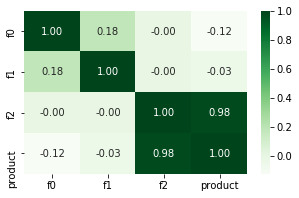

In [13]:
#посмотрим коэф. корреляции методом Спирмена
plt.figure(figsize=(5,3))
sns.heatmap(df_geo_1.corr(method='spearman'), annot=True, cmap="Greens", fmt='.2f')

наблюдается сильная зависимость у f2 и product

### df_geo_2

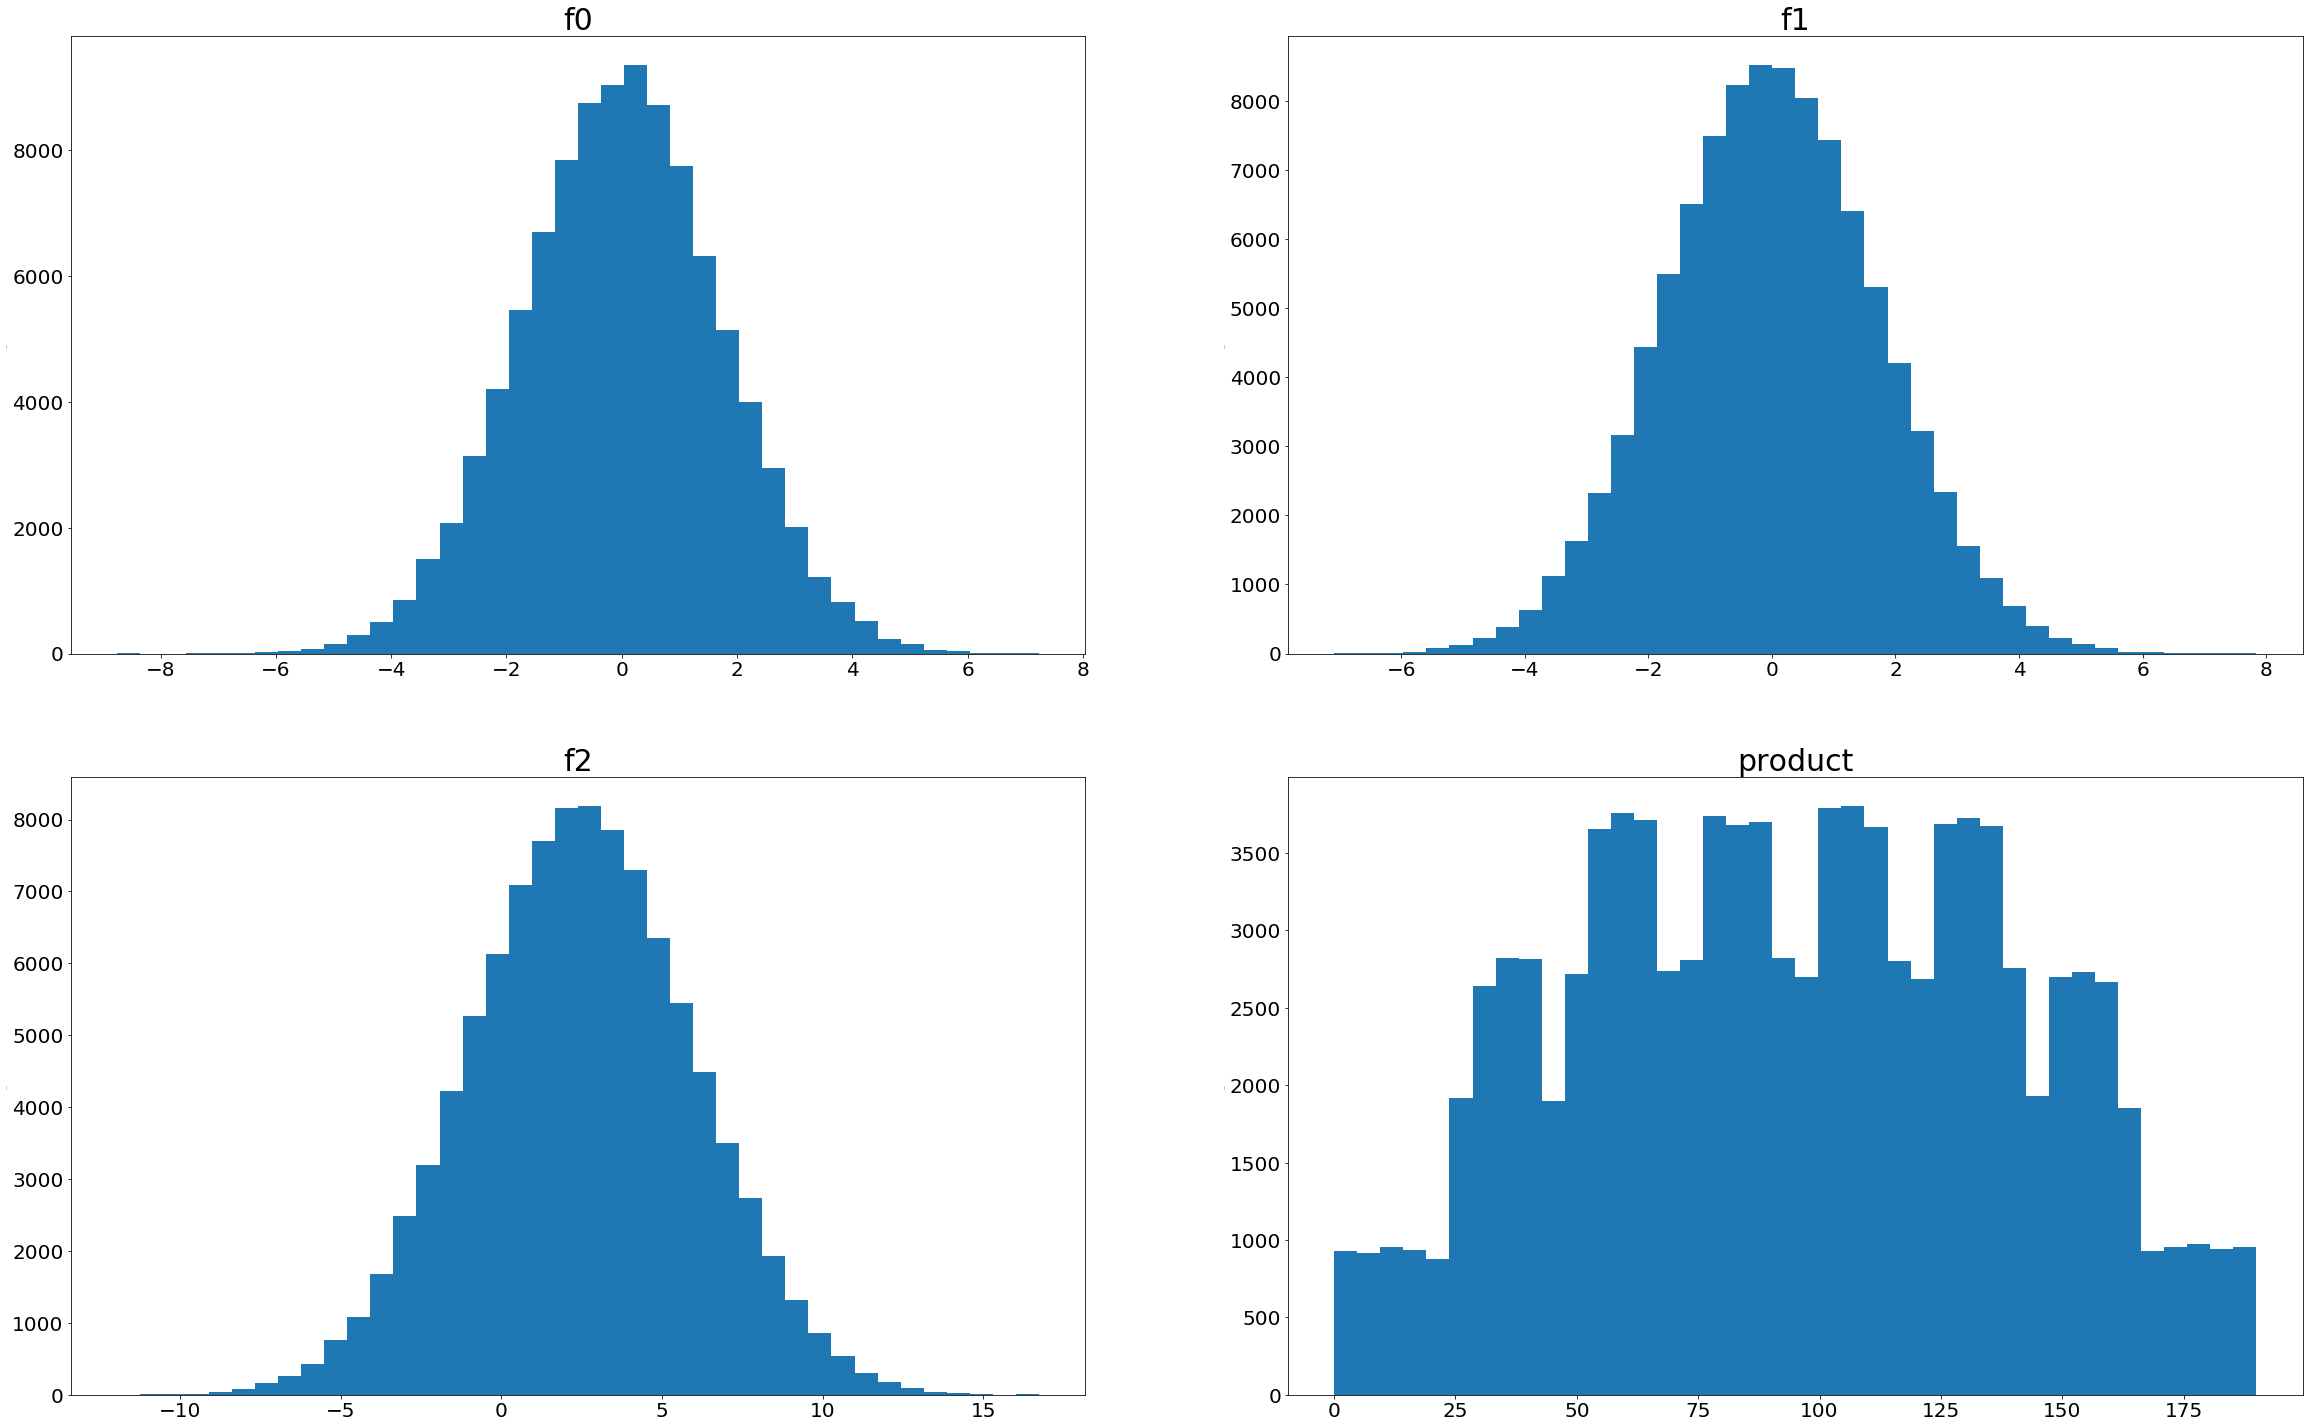

In [14]:
#посмотрим распределение данных
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(40,25))
column_list = ['f0', 'f1', 'f2', 'product']

count = 0
for r in range(rows):
    for c in range(cols):
        ax = df_geo_2[column_list[count]].plot(kind='hist', bins=40, ax=axes[r,c], fontsize=20, title=column_list[count])
        ax.set_title(column_list[count])
        ax.title.set_size(30)
        ax.yaxis.label.set_size(0)
        count += 1

f0, f1, f2 имеют нормальное распределение

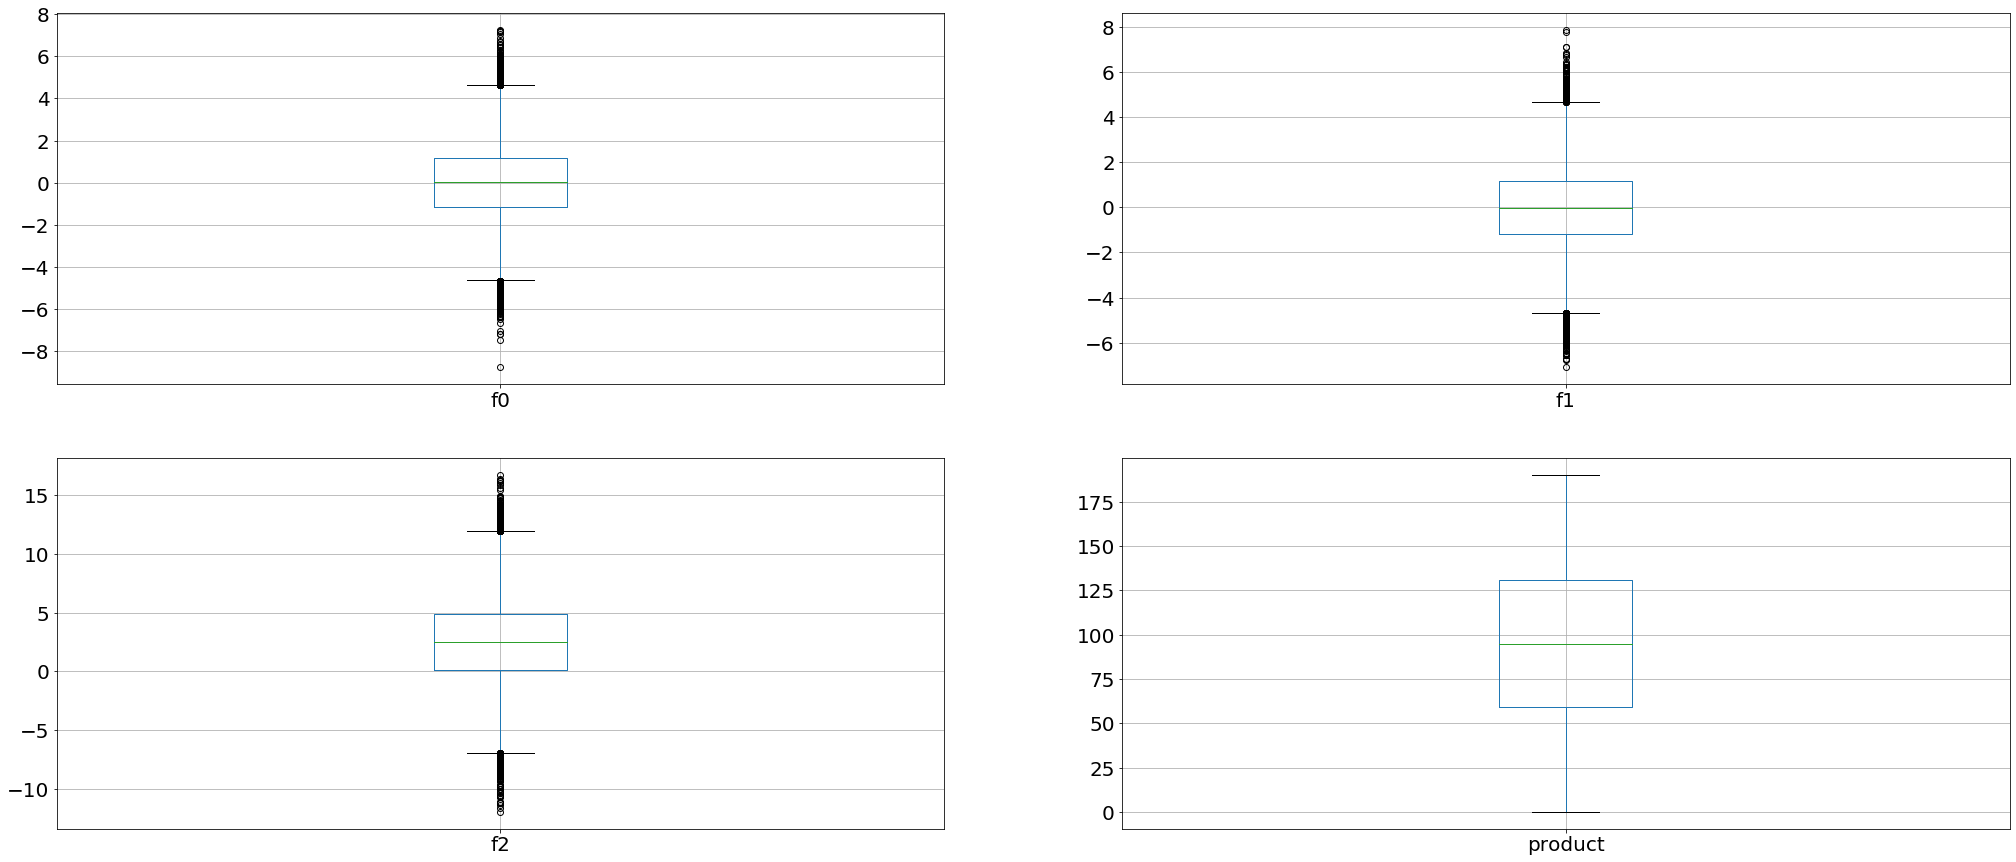

In [15]:
#посмотрим выбросы данных
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(35,15))
column_list = ['f0', 'f1', 'f2', 'product']

count = 0
for r in range(rows):
    for c in range(cols):
        ax = df_geo_2.boxplot(column=column_list[count], ax=axes[r,c], fontsize=20)
        count += 1

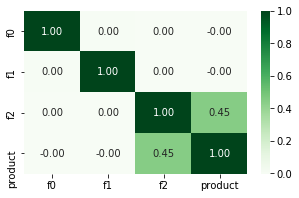

In [16]:
#посмотрим коэф. корреляции методом Спирмена
plt.figure(figsize=(5,3))
sns.heatmap(df_geo_2.corr(method='spearman'), annot=True, cmap="Greens", fmt='.2f')

наблюдается зависимость у f2 и product

## Выводы

пропусков в данных нету

дубликаты в данных удалены

удалили id, т.к. он не влияет на расчета моделей

все признаки - количественного типа, решаем задачу регрессии
целевая переменная - product

в df_geo_0 только f2 имеет нормальное распределение;
в df_geo_1 только f1 имеет нормальное распределение;
в df_geo_2 нормальное распределение имеют f0, f1, f2;

в df_geo_0 и df_geo_2 наблюдается зависимость у f2 и product;
в df_geo_1 наблюдается более сильная зависимость у f2 и product;


# 2. Обучение и проверка модели

In [17]:
#функция построения модели и расчета показателей
res = []
def train_model(df, rnd_state):
    target = df['product']
    features = df.drop(['product'], axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, random_state=rnd_state, test_size=0.25)
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    predict_valid = model.predict(features_valid)
    
    mse = mean_squared_error(target_valid, predict_valid)
    rmse = mse**0.5
    r2 = r2_score(target_valid, predict_valid)
    #Комментарий наставника: лучше брать среднее по тренировочной выборке (имитируем обучение модели), а
    #оценивать по валидационной (как обычные модели)
    predict_const = [target_train.mean() for i in range(len(target_train))]
    mse_const = mean_squared_error(target_train, predict_const)
    rmse_const = mse_const**0.5
    
    res.append([r2, rmse, rmse_const, predict_valid.mean()])
    
    return pd.DataFrame({'predicted_valid': predict_valid, 'target_valid': target_valid})

In [18]:
#проведем расчеты по каждому датасету
df_geo_0_pred = train_model(all_df[0], rnd_state)
df_geo_1_pred = train_model(all_df[1], rnd_state)
df_geo_2_pred = train_model(all_df[2], rnd_state)

In [19]:
#посмотрим на результаты
result = []
result = pd.DataFrame(data=res, columns=['r2', 'rmse', 'rmse_const', 'mean']).rename(index={0: 'geo_0', 1: 'geo_1', 2: 'geo_2'})
display(result)

,r2,rmse,rmse_const,mean
geo_0,0.277232,37.612985,44.303831,92.660946
geo_1,0.999625,0.887373,45.992996,69.019270
geo_2,0.200737,39.994906,44.754084,95.272790


geo_0 и geo_2 имеют примерно одинаковые средние значение объема в месторождении, при этом модели имеют бoльшую погрешность в прогнозировании.

geo_1 средние значение объема в месторождении ниже, однако модель научилась хорошо предсказывать, погрешность модели значительно меньше.

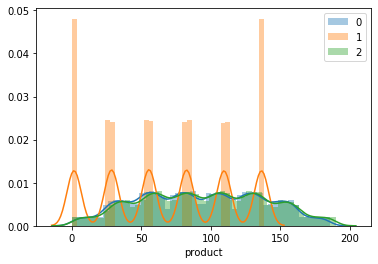

In [20]:
for i, df in enumerate(all_df):
    sns.distplot(df['product'], label=i)
    plt.legend()

у df_geo_1 распределнение запасов отличается от df_geo_0 и df_geo_2. В df_geo_1 ярко выраженные всплески, где сконцетрированы месторождения. Большая линейная зависимость f2 от product в df_geo_1 влияет на качество линейной модели.

# 3. Подготовка к расчёту прибыли

In [21]:
TOTAL_BUDGET = 10000000000
ONE_WELL_PROFIT = 450000
WELL_POINTS = 500
TOP = 200
ONE_WELL_COST = 50000000
RISK_TRESHOLD = 0.025
CONF_INTERVAL = 0.95
BOOTSTRAP_SAMPLES = 1000

In [22]:
#Рассчитаем достаточный объём сырья для безубыточной разработки 
FREE_VOL = TOTAL_BUDGET / ONE_WELL_PROFIT
FREE_VOL

22222.222222222223

In [23]:
#Рассчитаем минимальный объём сырья для безубыточной разработки новой скважины в регионе
MIN_BAR = ONE_WELL_COST / ONE_WELL_PROFIT
MIN_BAR

111.11111111111111

In [24]:
result['mean']

geo_0    92.660946
geo_1    69.019270
geo_2    95.272790
Name: mean, dtype: float64

Средний объем сырья месторождений во всех регионах меньше, чем минимальный объём сырья для безубыточной разработки новой скважины

In [25]:
#сравнение со средним объемом нефти в скважине по каждому региону
result['count_well'] =  FREE_VOL / result['mean']
result['diff_well'] =  result['mean'] - FREE_VOL/TOP
result

,r2,rmse,rmse_const,mean,count_well,diff_well
geo_0,0.277232,37.612985,44.303831,92.660946,239.822958,-18.450165
geo_1,0.999625,0.887373,45.992996,69.019270,321.971271,-42.091841
geo_2,0.200737,39.994906,44.754084,95.272790,233.248363,-15.838321


In [26]:
#Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели
def revenue(df_pred):
    top = df_pred.sort_values('predicted_valid', ascending=False).iloc[:TOP, 1] 
    return (top.sum()*ONE_WELL_PROFIT - TOTAL_BUDGET)

### Выводы

Для безубыточного производства необходимо добывать минимум 22222.222222222223 баррелей, при кол-ве скважин для разработки = 200 шт., минимальный объем сырья должен быть 111.11111111111111 баррелей

Во всех регионах средний показатель не подходит для безубыточности. 2 наиболее подходящий регион по расчету минимального кол-ва скважин для добычи, а 1 наимение подходящий из всех. 

# 4. Расчёт прибыли и рисков 

In [27]:
random_state = np.random.RandomState(seed=rnd_state)
bootstrap = []

In [28]:
#функция бутстрепа для каждого региона, прибыль и доверительный интервал
def profit_bootstrap(df, random_state):
    values = []
    for i in range(BOOTSTRAP_SAMPLES):
        subsample = df.sample(n=WELL_POINTS, replace=True, random_state=random_state)
        rev_s = revenue(subsample)
        values.append(rev_s)
        
    values = pd.Series(values)
    
    interval = st.t.interval(alpha=CONF_INTERVAL, df=len(values)-1, loc = values.mean(), scale = values.sem())
    val_ = pd.Series(values) < 0
    
    bootstrap.append([values.mean(), interval, values.quantile(RISK_TRESHOLD), val_.sum()/len(val_)])
    
    sns.distplot(values)
    plt.legend(['geo_0','geo_1', 'geo_2'])

In [29]:
all_pred = [df_geo_0_pred, df_geo_1_pred, df_geo_2_pred]

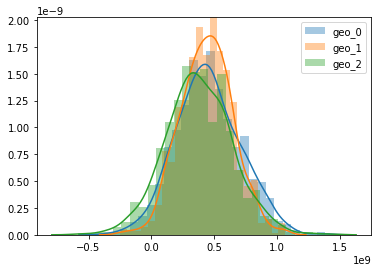

In [30]:
for i in range(3):
    profit_bootstrap(all_pred[i], random_state)

In [31]:
#посмотрим на итоговую таблицу
final_result = []
final_result = pd.DataFrame(data=bootstrap, columns=['средняя выручка', 'дов.интервал', '2.5% квантиль', '% убыточных скважин']).rename(index={0: 'geo_0', 1: 'geo_1', 2: 'geo_2'})
display(final_result)

,средняя выручка,дов.интервал,2.5% квантиль,% убыточных скважин
geo_0,4.523428e+08,"(436365921.27757967, 468319687.11573696)",-3.574358e+07,0.032
geo_1,4.405344e+08,"(427721240.396073, 453347550.7918298)",6.030675e+07,0.015
geo_2,3.782175e+08,"(361690662.0405801, 394744383.2212383)",-1.481777e+08,0.073


### Выводы:

Наиболее перспективный регион для добычи - geo_1: он наиболее предсказуемый и имеет самый низкий % убыточных скважин.
    
Второй наиболее подходящий регион - geo_0.

